# Diabetic patients readmission rates preditction


In [176]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn 

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
from learn2learn.algorithms.maml import MAML
from learn2learn.data import TaskDataset

from tqdm import tqdm

# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [177]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
mapping_info = pd.read_csv("Dataset/IDS_mapping.csv", header=None)

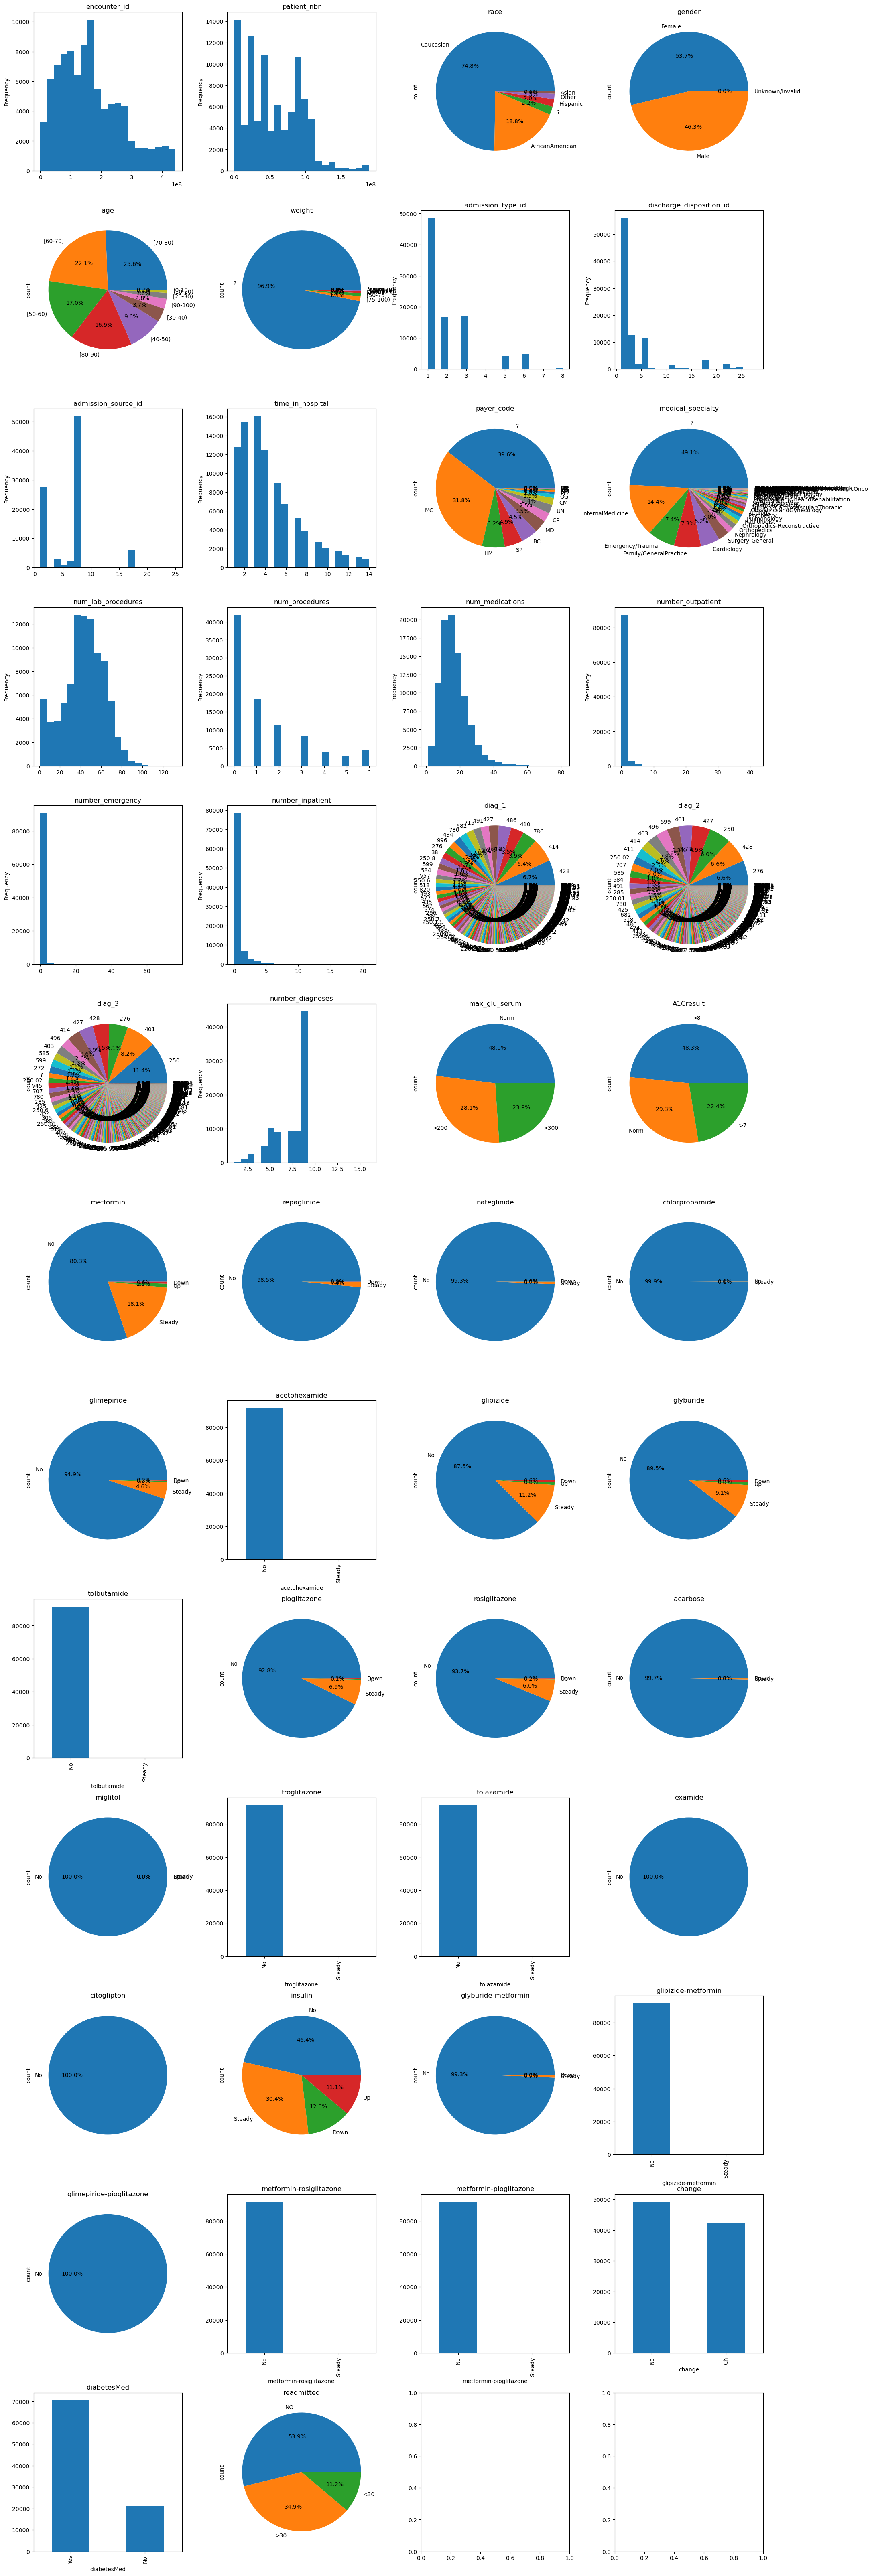

In [178]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)

# Creating a 4x4 subplot layout
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 65))
fig.tight_layout(pad=5.0)

# Iterate through each column and plot
for i, col in enumerate(train_data.columns):
    # Adjust this line to select different subsets of columns  
    plot_column(axes[i//4, i%4], col,train_data)


plt.show()


# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [179]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step
df = train_data.copy()

df.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
'glimepiride-pioglitazone'],inplace=True)
df.replace('?', np.nan, inplace=True)

df_test = test_data.copy()
df_test.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
'glimepiride-pioglitazone'],inplace=True)
df_test.replace('?', np.nan, inplace=True)

In [180]:
df['age'] = (df['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2
df_test['age'] = (df_test['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df_test['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2


In [181]:
df = df[df['race'] != '?']
print(df.any(axis=1).sum())

91589


One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories


1. random forest, remove ?
2. randomly assign ? to a class by disstribution

General Missing value
1. multiple imputation To be decide when training if less than 1h 5 epoch
2. mean
3. fullly remove
4. wrong -> fix ?


Encoding for age:
1. Asumming normal distribution, map to a random age in the range
2. Map to mean age in the range

In [182]:
def one_hot_encode(feature):
    """
    Takes a series and one-hot encodes it.
    
    Parameters:
    df (pandas.series): series containing a colum of the feature matrix.

    Returns:
    np.ndarray: A ndarray one-hot encoded.
    """
    encoded_df = pd.get_dummies(feature).values
    return encoded_df

In [183]:
df = df[df['gender'] != 'Unknown/Invalid']
Name = ['race','gender','change','diabetesMed']
df_encoded = pd.get_dummies(df, columns=Name, prefix=Name)

df_test_encoded = pd.get_dummies(df_test, columns=Name, prefix=Name)

In [184]:
category_mapping = {category: i for i, category in enumerate(df_encoded['medical_specialty'].unique())}
df_encoded['medical_specialty'] = df_encoded['medical_specialty'].map(category_mapping)
df_test_encoded['medical_specialty'] = df_test_encoded['medical_specialty'].map(category_mapping)

In [185]:
category_mapping = {category: i for i, category in enumerate(df_encoded['payer_code'].unique())}
df_encoded['payer_code'] = df_encoded['payer_code'].map(category_mapping)
df_test_encoded['payer_code'] = df_test_encoded['payer_code'].map(category_mapping)

In [186]:
medicion_mapping = {'No':0,'Down':1,'Steady':2,'Up':3}
max_glu_serum_mapping = {'>200': 2, '>300': 3, 'Norm': 1}
A1Cresult_mapping = {'>8':3,'>7':2,'Norm':1}
readmitted_mapping = {'NO':0,'<30':1,'>30':2}

In [187]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping)
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].fillna(0)

df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping)
df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].fillna(0)

In [188]:
df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping)
df_encoded['A1Cresult'] = df_encoded['A1Cresult'].fillna(0)

df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping)
df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].fillna(0)

In [189]:
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)

df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

In [190]:
for index,name in enumerate(df_encoded.columns):
    if(index >= 19 and index <= 38):
        df_encoded[name] = df_encoded[name].map(medicion_mapping)

for index,name in enumerate(df_test_encoded.columns):
    if(index >= 19 and index <=38):
        df_test_encoded[name] = df_test_encoded[name].map(medicion_mapping)

encode payer_code, medical_specialty
1. Find correlation internally with other feature in group of non-missing value
2. Use identified feature predict payer-code, medical_specialty
3. Prediction algorithm to be decide, could be KNN

encode diag_1,diag_2,diag_3
1. one hot
2. ????????????? TBD
3. remove missing

encoding all medicine:
map to 0-3

In [191]:
data = {
    'Feature1': ['A', 'B', 'A', 'C', 'B', 'C', 'A', 'B', 'C', 'A'],
    'Feature2': ['X', 'Y', 'X', 'Z', 'Y', 'Z', 'X', 'Y', 'Z', 'X'],
    'Target': [0, 1, 2, 0, 1, 2, 0, 2, 1, 0]
}
df = pd.DataFrame(data)

# 分割数据
X_train, X_test, y_train, y_test = train_test_split(df[['Feature1', 'Feature2']], df['Target'], test_size=0.2, random_state=42)

# 计算Feature1和Feature2的目标均值
for feature in ['Feature1', 'Feature2']:
    for target_class in range(3):
        mean_col_name = f'{feature}_{target_class}_Encoded'
        means = X_train.join(y_train).groupby(feature).apply(lambda x: (x['Target'] == target_class).mean())
        X_train[mean_col_name] = X_train[feature].map(means)
        X_test[mean_col_name] = X_test[feature].map(means)

print("训练集:\n", X_train)
print("测试集:\n", X_test)

训练集:
   Feature1 Feature2  Feature1_0_Encoded  Feature1_1_Encoded  \
5        C        Z                0.50                 0.0   
0        A        X                0.75                 0.0   
7        B        Y                0.00                 0.5   
2        A        X                0.75                 0.0   
9        A        X                0.75                 0.0   
4        B        Y                0.00                 0.5   
3        C        Z                0.50                 0.0   
6        A        X                0.75                 0.0   

   Feature1_2_Encoded  Feature2_0_Encoded  Feature2_1_Encoded  \
5                0.50                0.50                 0.0   
0                0.25                0.75                 0.0   
7                0.50                0.00                 0.5   
2                0.25                0.75                 0.0   
9                0.25                0.75                 0.0   
4                0.50               

In [192]:

X_train = df_encoded.drop('readmitted', axis=1)
Y_train = df_encoded['readmitted']

features = ['admission_type_id','discharge_disposition_id','admission_source_id']

'''for name in names:
    category_means = df_encoded.groupby(name)['readmitted'].mean().reset_index()
    category_means.columns = [name,name+'_readmitted_Mean']
    df_encoded = pd.merge(df_encoded, category_means, on=name, how='left')
    df_encoded = df_encoded.drop(name, axis=1)'''


for feature in features:
    for target_class in range(3):
        mean_col_name = f'{feature}_{target_class}_Encoded'
        means = X_train.join(y_train).groupby(feature).apply(lambda x: (x['Target'] == target_class).mean())
        df_encoded[mean_col_name] = df_encoded[feature].map(means)
        df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)
    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)


In [193]:
df_encoded.columns

Index(['age', 'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'readmitted',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male', 'change_Ch', 'change_No',
       'diabetesMed_No', 'diabetesMed_Yes', 'admission_type_id_0_Encoded',
       'admission_type_id_1_Encoded', 'admission_type_id_2_Encoded',
       'discharge_dispositi

In [194]:
df_encoded.drop(columns=['diag_1'], inplace=True)
df_encoded.drop(columns=['diag_2'], inplace=True)
df_encoded.drop(columns=['diag_3'], inplace=True)
df_encoded.drop(columns=['number_diagnoses'], inplace=True)

df_test_encoded.drop(columns=['diag_1'], inplace=True)
df_test_encoded.drop(columns=['diag_2'], inplace=True)
df_test_encoded.drop(columns=['diag_3'], inplace=True)
df_test_encoded.drop(columns=['number_diagnoses'], inplace=True)

In [195]:
# this part will recognise the ?, the missing value in training data
# When we have recognised it, we will use **** method to full up it
# the method we can discuss: 
#   delete
#   mean,median or mode
#   knn to predict
#   Multiple Imputation
predict_nan = df_encoded.copy()


df_real_ms_index = predict_nan.index[predict_nan['medical_specialty'] != 0]
unique_rows_index = predict_nan.index[predict_nan['medical_specialty'].duplicated(keep=False)]
df_real_ms_index_total = df_real_ms_index.join(unique_rows_index,how = 'inner')

df_real_pc_index = predict_nan.index[predict_nan['payer_code'] != 0]
unique_rows_index = predict_nan.index[predict_nan['payer_code'].duplicated(keep=False)]
df_real_pc_index_total = df_real_pc_index.join(unique_rows_index,how = 'inner')

df_real_ms = predict_nan.loc[df_real_ms_index_total,['medical_specialty']]
df_real_pc = predict_nan.loc[df_real_pc_index_total,['payer_code']]

predict_nan.drop(columns = ['medical_specialty','payer_code'],inplace = True)

df_data_train_ms = predict_nan.loc[df_real_ms_index_total]
df_data_predict_ms = predict_nan.loc[~predict_nan.index.isin(df_real_ms_index)]

df_data_train_pc = predict_nan.loc[df_real_pc_index_total]
df_data_predict_pc = predict_nan.loc[~predict_nan.index.isin(df_real_pc_index)]

In [196]:
# this part will reduce the dimension our training data

missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
missing_value_predict_model.fit(df_data_train_ms,df_real_ms['medical_specialty'])
df_encoded['medical_specialty'].loc[~df_encoded['medical_specialty'].index.isin(df_real_ms_index)] = missing_value_predict_model.predict(df_data_predict_ms)



missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
missing_value_predict_model.fit(df_data_train_pc,df_real_pc)
df_encoded['payer_code'].loc[~df_encoded['payer_code'].index.isin(df_real_pc_index)] = missing_value_predict_model.predict(df_data_predict_pc)

/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/3674376285.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['medical_specialty'].loc[~df_encoded['medical_specialty'].index.isin(df_real_ms_index)] = missing_value_predict_model.predict(df_data_predict_ms)
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/3674376285.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [197]:
features = ['medical_specialty', 'payer_code']
for feature in features:
    for target_class in range(3):
        mean_col_name = f'{feature}_{target_class}_Encoded'
        means = X_train.join(y_train).groupby(feature).apply(lambda x: (x['Target'] == target_class).mean())
        df_encoded[mean_col_name] = df_encoded[feature].map(means)
        df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)
    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)

Dems Redct
1. PCA/PPCA
2. LDA/QDA
3. following to T-SNE
3. Autoencoders
4. Unsupervised Algorithmn

In [198]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Simulating Data
np.random.seed(0)
num_samples = 1000
num_features = 5

# Numerical data
numeric_data = np.random.randn(num_samples, num_features)

# Categorical data (let's say, colors)
colors = ['Red', 'Green', 'Blue']
categorical_data = np.random.choice(colors, size=num_samples)

# Convert categorical data to one-hot encoding
encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(categorical_data.reshape(-1, 1))

# Combining numerical and categorical data
combined_data = np.hstack((numeric_data, categorical_encoded))

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(scaled_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plotting the results
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=categorical_data, palette='bright')
plt.title('t-SNE plot of the dataset')
plt.xlabel('t-SNE Axis 1')


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NameError: name 'sns' is not defined

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_shape = combined_data.shape[1]  # combined data from previous steps
encoding_dim = 32  # example of encoding dimension

# This is our input placeholder
input_data = Input(shape=(input_shape,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_shape, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(combined_data, combined_data, epochs=50, batch_size=256, shuffle=True)


# Model Building
We will build two models: 
1. A traditional machine learning model using Random Forest.
2. A deep learning model using PyTorch.


At the first step we will try to use the Random Forest method to get the result

In [ ]:
# the code for Random Forest algorithm

In [ ]:
# the code for Nerual Network

# Model Training


In [199]:
df_encoded['A1Cresult'].value_counts()

A1Cresult
0.0    76279
3.0     7398
1.0     4479
2.0     3430
Name: count, dtype: int64

In [200]:
(df_normalized.astype(float) < 0).any()

age                                         True
time_in_hospital                            True
payer_code                                  True
medical_specialty                           True
num_lab_procedures                          True
num_procedures                              True
num_medications                             True
number_outpatient                           True
number_emergency                            True
number_inpatient                            True
max_glu_serum                               True
A1Cresult                                   True
metformin                                   True
repaglinide                                 True
nateglinide                                 True
chlorpropamide                              True
glimepiride                                 True
acetohexamide                               True
glipizide                                   True
glyburide                                   True
tolbutamide         

In [205]:
# training loop
# Random Forest
from sklearn.feature_selection import SelectKBest, chi2

# 选择最好的K个特征


Y = df_encoded['readmitted']
#df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = df_encoded.drop('readmitted', axis=1)

selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, Y)


rf_classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
rf_classifier.fit(X, Y)

# Nerual Network

HistGradientBoostingClassifier(random_state=42)

In [202]:

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, Y)

RandomForestClassifier()

# Model Evaluation

In [207]:
# use testing dataset to predict
Y_test = df_test_encoded['readmitted']
#df_test_normalized = pd.DataFrame(scaler.fit_transform(df_test_encoded), columns=df_test_encoded.columns)
X_test = df_test_encoded.drop('readmitted', axis=1)
#X_test = selector.transform(X_test)

Y_pred = rf_classifier.predict(X_test)
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))

[0 0 0 ... 0 0 2]
0        0
1        2
2        0
3        0
4        2
        ..
10172    2
10173    0
10174    0
10175    1
10176    2
Name: readmitted, Length: 10177, dtype: int64
0.5851429694408962


In [208]:
Y_pred = classifier.predict(df_test_encoded.drop('readmitted', axis=1))
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))

[0 0 0 ... 0 0 2]
0        0
1        2
2        0
3        0
4        2
        ..
10172    2
10173    0
10174    0
10175    1
10176    2
Name: readmitted, Length: 10177, dtype: int64
0.5586125577282107
